## Preliminary results of COVID-19 vaccines: a Bayesian analysis


Nowadays, the COVID-19 pandemic pushed scientists from several countries to investigate/develop vaccines. Many countries, such as China, UK, India and US, are in a race to develop trustable vaccines, indicating high efficiencies.

                                                                    Marcus Duarte - 20/11/2020
                                                                    Data Scientist
                                                                    mvcduarte at gmail.com    
                                                                    https://www.linkedin.com/in/marcus-duarte-478bab81/    

### Context

Recently, some health companies pointed out that their vaccines (e.g. Oxford, Sinovac, Pfizer and BioNtech) presented efficienty of ~90%-95% in premilinary results, being quite promissing! It means the rate of people who got the vaccine and got immunized by COVID-19 is around 95%, much higher than expected by WHO (World Health Organization).

Our study aim to evaluate how reliable those numbers are and calculate a probability that, base on those numbers, the vaccines fail. The **PyMC3 package** will be used to employ the MCMC (Monte Carlo Markov Chain) technique and define probabilities.    

### Bayes Theorem

The Bayes theorem consists of a probabilistic model which the posterior probability $P(\theta|X)$ is proportional to the likelihood $P(X|\theta)$ times a certain prior $P(\theta)$, where $\theta$ and $X$ represents the parameters and the data, respectively. The Bayes Theorem can be written as, 

$$P(\theta|X) \propto P(X|\theta)P(\theta)$$



Note that in the aforementioned equation above, we do not consider the evidence $P(D)$. Since it is a normalization numerator and we just want to get the set of parameters ($\theta$) that maximizes the posterior, only the proportionality is enough for this problem. 

Since the problem approached here has only two options: vaccine worked or vaccine did not work, the Bernoulli distribution (aka flip-coin distribution) is used to represent our Likelihood. This distribution can be written as, 

$$Bernoulli(x) = p ^ {x} (1 - p) ^ {1 - x} \qquad \qquad x = 0, 1$$

and p is the probability that the vaccine works. 

The prior should be carefully chosen since it has an important impact on the results. Thus we have to choose a distribution that reflects our first guess, using a Beta function, 

$$Beta(x, a, b) = \frac{x^{p-1} (1-x)^{q-1}}{B(a, b)}$$

where, 

$$B(a, b) = \frac{\Gamma (a) \Gamma (b)}{\Gamma (a + b)};\ a,\ b\ >\ 0$$


Note that we can evaluate the Beta distribution by plotting distinct combinations of $a$ and $b$. 
The Figure below shows some combinations of $a,\ b > 0$ and different shapes of Beta distribution. 


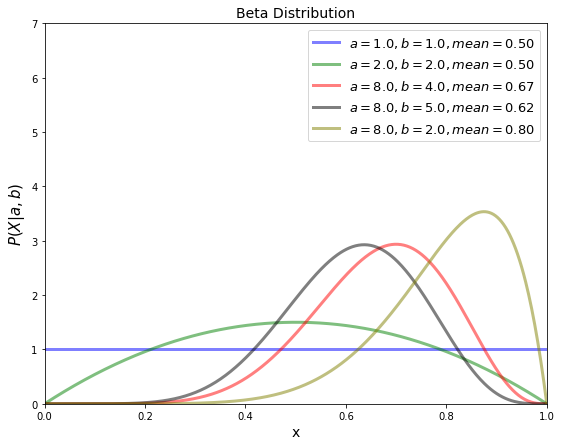

In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as sstat
import arviz as az
import pymc3
from scipy.integrate import simps
%matplotlib inline

a_vals = [1., 2.0, 8., 8., 8.]
b_vals = [1., 2.0, 4., 5., 2.]
colors = ['blue', 'green', 'red', 'black', 'olive']

x = np.linspace(0, 1, 500)
plt.figure(figsize=(9, 7))
for i, a in enumerate(a_vals):
    
    # Define beta distribution
    
    betadist = sstat.beta(a, b_vals[i])
    betapdf = betadist.pdf(x)
    
    # Calculate the mean of beta distribution
    
    mean = sstat.beta.stats(a, b_vals[i], moments = 'm')

    # Plot it 
    
    plt.plot(x, betapdf, color = colors[i], label = r'$a = %.1f, b = %.1f, mean= %.2f $'%(a, b_vals[i], mean), lw = 3., alpha = 0.5)
    
plt.xlim(0., 1.)
plt.ylim(0, 7)
plt.xlabel('x', fontsize = 14)
plt.ylabel(r'$P(X | a, b)$', fontsize=15)
plt.title('Beta Distribution', fontsize=14)

plt.legend(loc=0, fontsize=13)
plt.show()

It is important to mention that for the case when $a=b=1$, the Beta distribution is notably flat. In this case, the Bayesian model becomes a simple maximization of likelihood ($P(\theta|X) \propto P(X|\theta)$). For this study, we chose a **pessimist prior**, being $a=8$ and $b=4$ (red line), with mean at 0.67. It indicates that our first guess about the efficiency of these vaccines is likely around 67%, quite lower than initially 95%! 

## PyMC3 model

Thus, our Bayesian model can be written as the follows, 

$$ P(\theta|X) \propto Beunoulli(X, p) Beta(X, a, b)$$

and our goal is to find the best $\theta$ that maximizes the posterior. Let us define the model in Python3 using PyMC3. This study can be also solved analitically since Bernoulli and Beta are conjugate priors. The usage of PyMC3 will allow us to generalize this model for other (not from known distributions) priors. 

In [2]:
def model_pymc3(alpha, beta, data, n_patient):
    ''' 
    PyMC3 model using Bernoulli (likelihood) and Beta (prior) distributions
    '''
    
    with pymc3.Model() as model: 
    
        # Prior -> Beta distribution
        
        bprior = pymc3.Beta('beta_n_patient' + str(n_patient), alpha = alpha, beta = beta) # we choose a beta prior for our parameter theta
        
        # Likelihood -> Bernoulli distribution (aka flip-coin function)
        
        bernoulli_likelihood = pymc3.Bernoulli('bernoulli', p = bprior, observed = data)
    
        # Run PyMC3
        
        trace = pymc3.sample(2000, tune = 500, chains = 5)
        
    return trace, model

In [3]:
n_patient = 1000 # Initially, let's consider this number of pacients for the experiment
frac_efficiency = 0.95 # 95% of efficiency

# Sampling the Bernoulli distribution

data = sstat.bernoulli.rvs(frac_efficiency, size = n_patient)

heads = data.sum()
print ("Likelihood(frequentist):", float(heads) / float(n_patient))

Likelihood(frequentist): 0.941


Now, let us run the model and get the results!

In [4]:
# Parameters for Beta function chosen above (pessimist)

a = 8.
b = 4.

# Run PyMC3

trace, model = model_pymc3(a, b, data, n_patient)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [beta_n_patient1000]


Sampling 5 chains for 500 tune and 2_000 draw iterations (2_500 + 10_000 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.8816765386998079, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/marcusduarte/sm_venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123e95b50>,
      dtype=object)

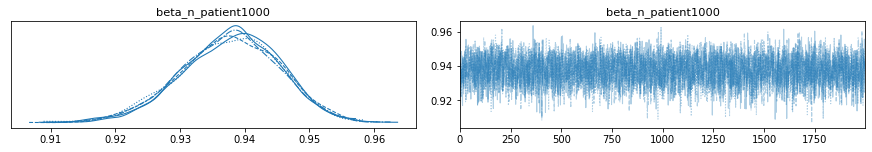

In [5]:
pymc3.traceplot(trace)

/Users/marcusduarte/sm_venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


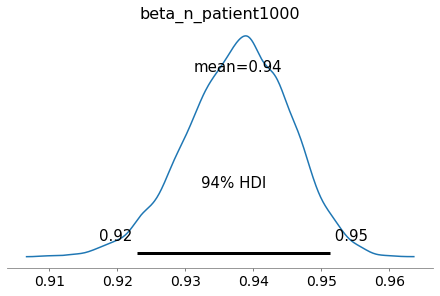

In [6]:
az.plot_posterior(trace)

The Figure above shows the posterior distribution, indicating a peak around 95%. It means that according to the Bayes model, even if on thinks that the COVID-19 efficiency can be lower (peaking at 67% and including this information in the prior), the strength of the data/results of patients is so robust that the model still indicates a peak around 95%, with confidence intervals between 94% and 97%. For instance, the probability of this efficiency to be actually below 94% can be calculate by the area below the curve above from 0% to 94%. 

## How many patients we need in the experiment to say that the result is robust/reliable?

**Now, let us do the following exercise. What is the minimum number of patients to guarantee that the result of 95% is robust, i.e., the efficiency will keep above a certain threshold?** Here, we define robust being the probability of the efficiency being below 90% of efficiency. 

In [7]:
# Define the number of patients

n_patients = np.arange(100, 1001, 100)
print(n_patients)

# Define a function to calculate the probability above a certain threshold, given a PDF

def calc_prob(prob_array, bin_array, threshold):    
    idx = np.where(bin_array < threshold)[0]
    return simps(prob_array[idx], bin_array[idx])

[ 100  200  300  400  500  600  700  800  900 1000]


number of patients= 100


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [beta_n_patient100]


Sampling 5 chains for 500 tune and 2_000 draw iterations (2_500 + 10_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8922904104054091, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/marcusduarte/sm_venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


prob_below_threshold= 48.26861597040109
*******************************************************************
number of patients= 200


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [beta_n_patient200]


Sampling 5 chains for 500 tune and 2_000 draw iterations (2_500 + 10_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8833325770072411, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/marcusduarte/sm_venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


prob_below_threshold= 52.04721599020993
*******************************************************************
number of patients= 300


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [beta_n_patient300]


Sampling 5 chains for 500 tune and 2_000 draw iterations (2_500 + 10_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8846438034851752, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/marcusduarte/sm_venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


prob_below_threshold= 8.362676056337994
*******************************************************************
number of patients= 400


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [beta_n_patient400]


Sampling 5 chains for 500 tune and 2_000 draw iterations (2_500 + 10_000 draws total) took 26 seconds.
/Users/marcusduarte/sm_venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


prob_below_threshold= 0.5057045439643295
*******************************************************************
number of patients= 500


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [beta_n_patient500]


Sampling 5 chains for 500 tune and 2_000 draw iterations (2_500 + 10_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8951491066647977, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/marcusduarte/sm_venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


prob_below_threshold= 0.5377166156982663
*******************************************************************
number of patients= 600


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [beta_n_patient600]


Sampling 5 chains for 500 tune and 2_000 draw iterations (2_500 + 10_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8869118029073241, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/marcusduarte/sm_venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


prob_below_threshold= 1.5387830157138065
*******************************************************************
number of patients= 700


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [beta_n_patient700]


Sampling 5 chains for 500 tune and 2_000 draw iterations (2_500 + 10_000 draws total) took 25 seconds.
/Users/marcusduarte/sm_venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


prob_below_threshold= 0.0
*******************************************************************
number of patients= 800


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [beta_n_patient800]


Sampling 5 chains for 500 tune and 2_000 draw iterations (2_500 + 10_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8821965001740137, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886742321768453, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/marcusduarte/sm_venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


prob_below_threshold= 0.0
*******************************************************************
number of patients= 900


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [beta_n_patient900]


Sampling 5 chains for 500 tune and 2_000 draw iterations (2_500 + 10_000 draws total) took 26 seconds.
/Users/marcusduarte/sm_venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


prob_below_threshold= 0.0
*******************************************************************
number of patients= 1000


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [beta_n_patient1000]


Sampling 5 chains for 500 tune and 2_000 draw iterations (2_500 + 10_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8823010572466873, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8843500773557931, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/marcusduarte/sm_venv/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


prob_below_threshold= 0.0
*******************************************************************


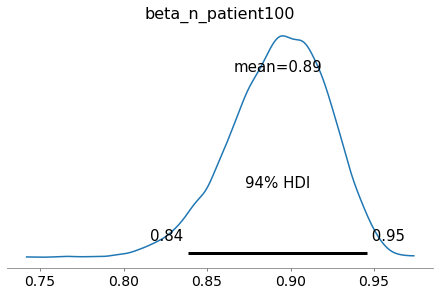

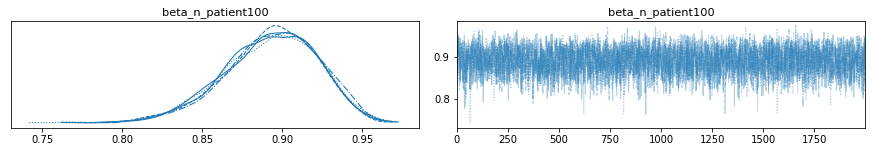

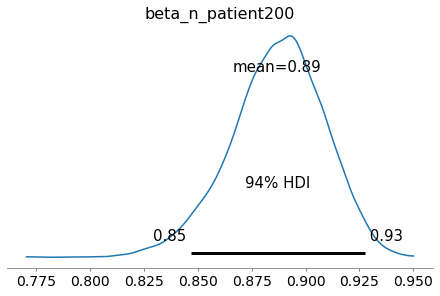

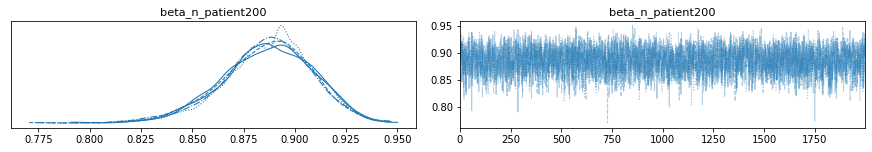

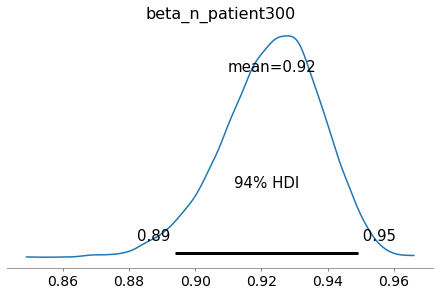

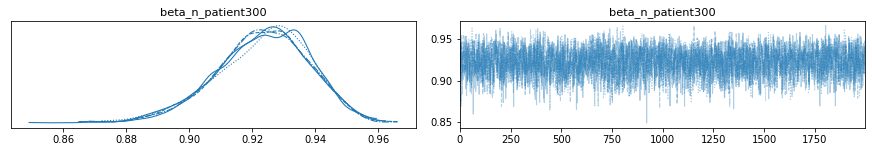

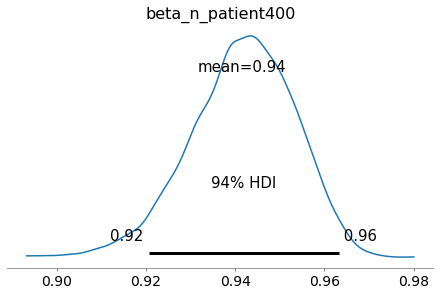

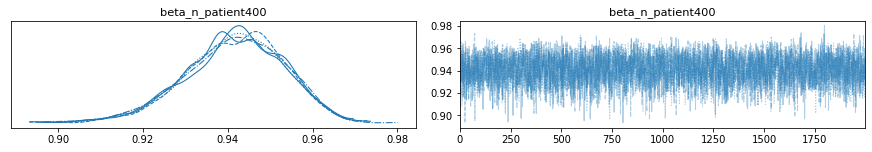

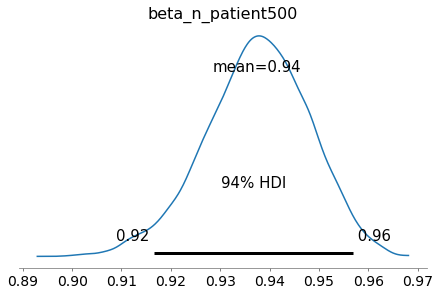

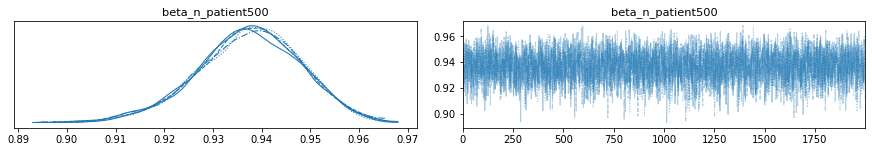

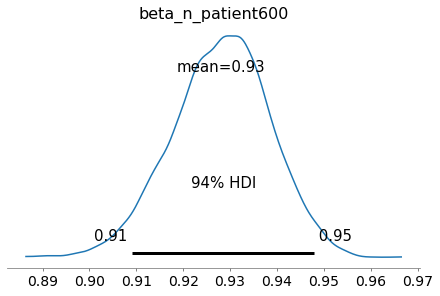

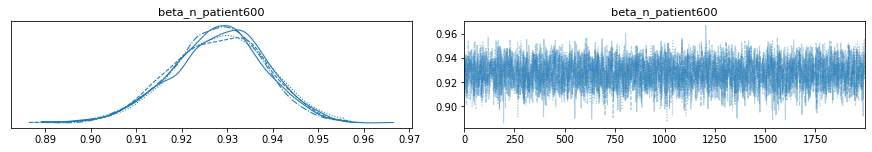

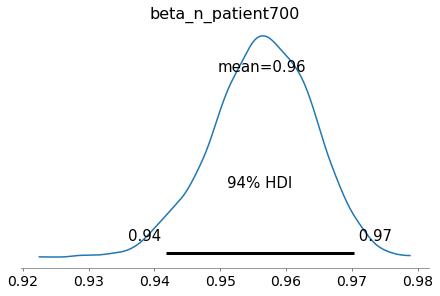

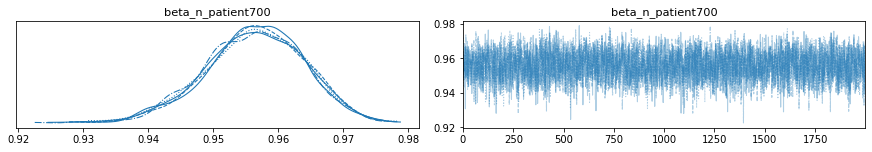

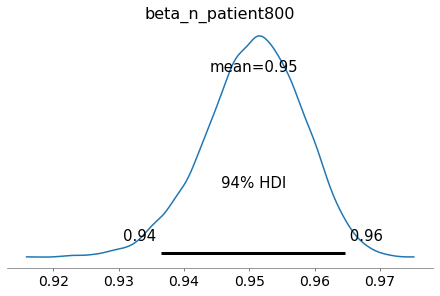

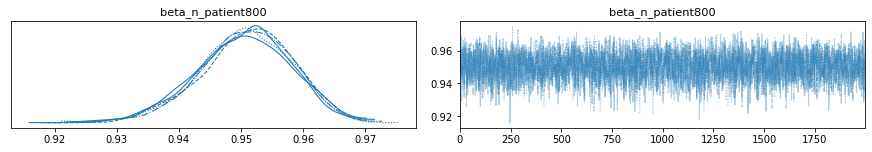

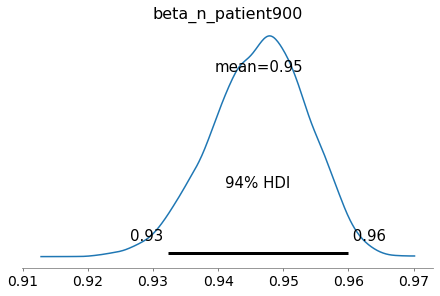

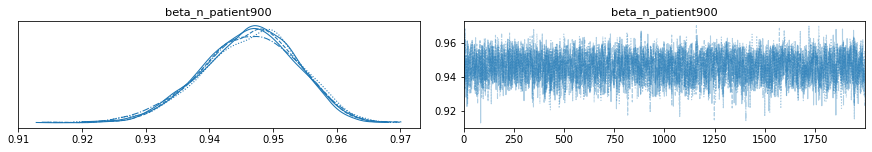

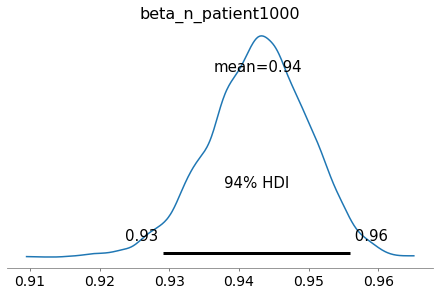

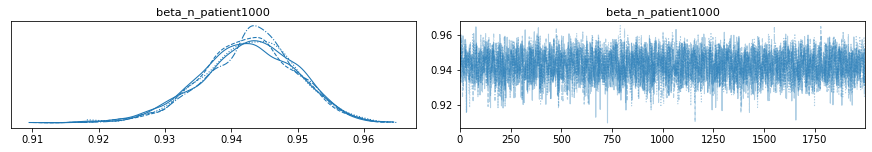

In [8]:
bins = np.linspace(0.0, 1., 70)
prob_below_threshold = np.zeros(len(n_patients))
for i, n in enumerate(n_patients):
    
    print('number of patients=', n)
    
    # Sampling the Bernoulli distribution, considering the same efficiency

    data = sstat.bernoulli.rvs(frac_efficiency, size = n)
    
    # Run PyMC3

    trace, model = model_pymc3(a, b, data, n)
    
    # Plot posterior
    
    az.plot_posterior(trace)
    pymc3.traceplot(trace)
    
    # Sampling the posterior PDF and get probabilities above threshold
    
    ppc = pymc3.sample_posterior_predictive(trace, samples = 10000, model = model)
    frac_vaccine_works = ppc['bernoulli'].sum(axis = 1) / ppc['bernoulli'].shape[1]
    probs, bins_edges = np.histogram(frac_vaccine_works, bins = bins, density = True)
    bin_centers = 0.5 * (bins_edges[1:] + bins_edges[:-1])
    prob_normalized = probs / simps(probs, bin_centers)

    # Threshold of 90% of efficiency
    
    prob_below_threshold[i] = calc_prob(prob_normalized, bin_centers, 0.90) * 100.
    print('prob_below_threshold=', prob_below_threshold[i])
    print('*******************************************************************')

No handles with labels found to put in legend.


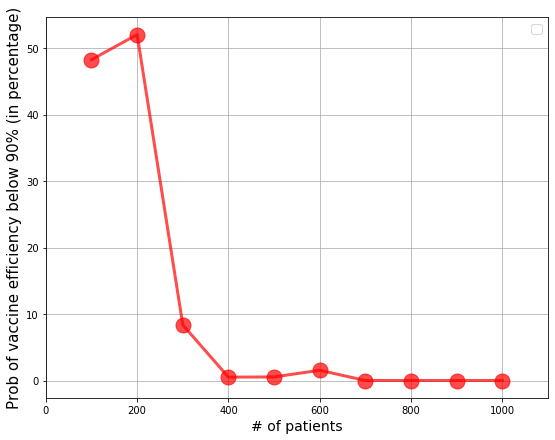

In [9]:
plt.figure(figsize=(9, 7))
plt.plot(n_patients, prob_below_threshold, '-o', color = 'red', markersize = 15, lw = 3., alpha = 0.7)
plt.xlim(0., max(n_patients) + 100.)
#plt.ylim(0., 0.1)
plt.xlabel(r'# of patients', fontsize = 14)
plt.ylabel(r'Prob of vaccine efficiency below 90% (in percentage)', fontsize = 15)
plt.legend(loc=0, fontsize=13)
plt.grid()
plt.show()

For number of patients above 800, the results of COVID-19 vaccine efficiency are quite robust (prob below 90% is roughly null) and it guarantees the current performance of 95% mentioned by news website and TV. For low number of people, the probability is quite high and not stable until 600.

Since the researchers of COVID-19 vaccine use tens of thousands of people in ech experiment, their conclusions are statistically robust. Our analysis considers that everyone (patients) have similar reactions to the vaccine and it explains why they consider a large number of people. 

Well, that is all for now! If you are interested in this analysis and want to know more, send me an e-mail.